In [2]:
import pandas as pd
import polars as pl
import polars.selectors as cs
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tempfile
import os
import zipfile
import shap
import plotly.io as pio
import plotly as plotly

plotly.offline.init_notebook_mode()
pio.renderers.default = "vscode+notebook"

In [3]:
def read_dataset_export(file_name, src_folder=".",
                        tmp_folder=None,
                        lazy=False,
                        verbose=False):
    json_file = None
    error_reason = ""
    tmp_folder = tmp_folder if tmp_folder else tempfile.gettempdir()

    if file_name.endswith(".json"):
        error_reason = "Error reading JSON file"
        if os.path.exists(file_name):
            json_file = file_name
        elif os.path.exists(os.path.join(src_folder, file_name)):
            json_file = os.path.join(src_folder, file_name)
        if json_file and verbose:
            print(error_reason, json_file)
        if json_file:
            if lazy:
                multi_line_json = pl.scan_ndjson(json_file)
            else:
                multi_line_json = pl.read_ndjson(json_file)

    else:
        zip_file = file_name
        if file_name.endswith(".zip"):
            error_reason = "Error reading ZIP file"
            if os.path.exists(file_name):
                zip_file = file_name
            elif os.path.exists(os.path.join(src_folder, file_name)):
                zip_file = os.path.join(src_folder, file_name)
            if verbose:
                print(error_reason, zip_file)

            if os.path.exists(zip_file):
                error_reason = "Error extracting data.json"
                if verbose:
                    print(error_reason, zip_file)

                json_file = os.path.join(tmp_folder, "data.json")
                if os.path.exists(json_file):
                    os.remove(json_file)

                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    all_zip_entries = zip_ref.namelist()
                    json_file_in_zip = [s for s in all_zip_entries if "data.json" in s]
                    if verbose:
                        print("data.json in zip file:", json_file_in_zip, zip_file)

                    for file in json_file_in_zip:
                        zip_ref.extract(file, tmp_folder)
                        json_file = os.path.join(tmp_folder, file)

                if not os.path.exists(json_file):
                    raise Exception(f"Dataset zipfile {zip_file} does not have \"data.json\"")
                if lazy:
                    multi_line_json = pl.scan_ndjson(json_file, infer_schema_length=100000)
                else:
                    multi_line_json = pl.read_ndjson(json_file, infer_schema_length=100000)
                    os.remove(json_file)

    if json_file is None:
        raise Exception(f"Dataset export not found {error_reason}")
    return multi_line_json

## Read and Pre-process data

In [4]:
df = read_dataset_export( "Web_ClickThrough.zip", lazy=True, verbose=True)
df.describe()

Error reading ZIP file Web_ClickThrough.zip
Error extracting data.json Web_ClickThrough.zip
data.json in zip file: ['data.json'] Web_ClickThrough.zip


shape: (9, 81)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Customer_ ┆ Customer_ ┆ IH_Web_In ┆ … ┆ IH_Web_In ┆ Customer_ ┆ IH_Web_In ┆ Customer │
│ ---       ┆ Residenti ┆ NetWealth ┆ bound_Cli ┆   ┆ bound_Imp ┆ PrimaryMo ┆ bound_Imp ┆ _OwnedAc │
│ str       ┆ alStatus  ┆ ---       ┆ cked_pxLa ┆   ┆ ression_p ┆ bilePhone ┆ ression_p ┆ countTyp │
│           ┆ ---       ┆ str       ┆ stO…      ┆   ┆ xLa…      ┆ ---       ┆ yHi…      ┆ es       │
│           ┆ str       ┆           ┆ ---       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆ str       ┆   ┆ str       ┆           ┆ str       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 32091     ┆ 32091     ┆ 32091     ┆ … ┆ 32091     ┆ 32091     ┆ 32091     ┆ 9513     │
│ null_coun ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 22578    │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ std       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ min       ┆           ┆           ┆ 0.0000055 ┆ … ┆ Creditcar ┆           ┆ 10.0      ┆          │
│           ┆           ┆           ┆ 208333333 ┆   ┆ ds        ┆           ┆           ┆          │
│           ┆           ┆           ┆ 33333     ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 50%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 75%       ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ max       ┆           ┆ 990953.0  ┆ 1.8533307 ┆ … ┆ Creditcar ┆           ┆ 9.0       ┆ Loan,    │
│           ┆           ┆           ┆ 87037037  ┆   ┆ ds        ┆           ┆           ┆ Loan,    │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Loan,    │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ Loan     │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [5]:
columns = df.collect_schema().names()
columns.sort()
columns

['Context_Channel',
 'Context_Direction',
 'Context_Group',
 'Context_Issue',
 'Context_Name',
 'Context_Treatment',
 'Customer_AnnualIncome',
 'Customer_BirthDate',
 'Customer_CLV',
 'Customer_CreditScore',
 'Customer_DebtToIncomeRatio',
 'Customer_HasBrokenPromise',
 'Customer_HasCriticalIllness',
 'Customer_IsActiveMilitaryService',
 'Customer_IsB2C',
 'Customer_IsBankruptcy',
 'Customer_IsCreditScoreStale',
 'Customer_IsCustomerActive',
 'Customer_IsFinanciallyVulnerable',
 'Customer_IsInActiveComplaint',
 'Customer_IsInArrears',
 'Customer_IsInCollections',
 'Customer_IsInDisasterArea',
 'Customer_IsInPrecollections',
 'Customer_IsIncarcerated',
 'Customer_IsProspect',
 'Customer_IsStudent',
 'Customer_LinkedIn',
 'Customer_MKTCLVValue',
 'Customer_NetWealth',
 'Customer_NumCreditCardAccount',
 'Customer_NumDepositAccount',
 'Customer_NumInvestmentAccount',
 'Customer_NumLoanAccount',
 'Customer_OrganizationID',
 'Customer_OrganizationName',
 'Customer_OwnedAccountTypes',
 'Custom

In [6]:
df = df.unique(subset=['Decision_InteractionID', 'Context_Treatment'], keep='last')

In [7]:
df = df.with_columns(
    pl.when(pl.col(pl.String).str.len_chars() == 0)
    .then(None)
    .otherwise(pl.col(pl.String))
    .name.keep()
    ).with_columns(
        cs.ends_with("_DaysSince", 
                     "_pyHistoricalOutcomeCount",
                     "DaysinCurrentStage")
                     .cast(pl.Float64).fill_null(0),
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities",
                "Customer_BirthDate"
            ]
            )
        .cast(pl.Float64)
        .fill_null(0),
        cs.starts_with("Customer_Num").cast(pl.Float64).fill_null(0),
        cs.starts_with("Context_").cast(pl.String),
        cs.starts_with("Customer_Is").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True}),
        cs.starts_with("Customer_Has").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True})
    ).with_columns(
        cs.starts_with("Customer_Is").fill_null(False).cast(pl.Boolean),
        cs.starts_with("Customer_Has").fill_null(False).cast(pl.Boolean)
    ).with_columns(
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities"
            ]
        ).cast(pl.Float64).fill_null(0),
    )

In [8]:
df = df.drop(["rulesetVersion", "id", "dataCenter", "negativeSampling", "positiveSampling", "rulesetName",
                "Decision_SubjectID", "Decision_OutcomeTime", "Decision_Rank", "Decision_InteractionID",
                "Decision_DecisionTime", "Decision_OutcomeWeight", "pyModelEvidence", "pyModelPerformance", 
                "pyModelPositives", "pyPropensity", "rulesetVersion"])


In [9]:
cat_features = list()
schema = df.collect_schema()

for cname in schema.names():
    ctype = schema[cname]
    if(not(cname.startswith("Decision_")) and pl.String.is_(ctype)):
        df = df.with_columns(pl.col(cname).fill_null('N/A'))
        cat_features.append(cname)
print(cat_features)

['Customer_ResidentialStatus', 'Param_JourneyStage', 'Customer_OrganizationID', 'Customer_PrimaryPostalCode', 'Context_Group', 'Customer_CLV', 'Context_Name', 'Customer_OwnershipStatus', 'Context_Direction', 'Param_LastJourneyStage', 'Customer_LinkedIn', 'Customer_Prefix', 'IH_Web_Inbound_Clicked_pxLastGroupID', 'IH_Retail_Inbound_Impression_pxLastGroupID', 'Context_Channel', 'Customer_MKTCLVValue', 'Context_Issue', 'Customer_PrimaryCountry', 'Customer_OrganizationName', 'Param_Journey', 'Context_Treatment', 'Customer_PrimaryState', 'Customer_PrimaryCountryCode', 'Param_PriorStageInJourney', 'Customer_PrimaryCity', 'IH_Web_Inbound_Impression_pxLastGroupID', 'Customer_PrimaryMobilePhone', 'Customer_OwnedAccountTypes']


In [10]:
text_processing_options = {
    "tokenizers": [{
        "tokenizer_id": "comma",
        "delimiter": ",",
        "lowercasing": "true"
    }],

    "dictionaries": [{
        "dictionary_id": "Word",
        "gram_order": "1"
    }],

    "feature_processing": {
        "default": [{
            "dictionaries_names": ["Word"],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["comma"]
        }]
    }
}
text_features = ['Customer_OwnedAccountTypes']


In [11]:
cat_features = list(set(cat_features) - set(text_features))

In [12]:
df = df.collect()
df.head()

shape: (5, 64)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Customer_ ┆ Customer_ ┆ IH_Web_In ┆ Param_Jou ┆ … ┆ IH_Web_In ┆ Customer_ ┆ IH_Web_In ┆ Customer │
│ Residenti ┆ NetWealth ┆ bound_Cli ┆ rneyStage ┆   ┆ bound_Imp ┆ PrimaryMo ┆ bound_Imp ┆ _OwnedAc │
│ alStatus  ┆ ---       ┆ cked_pxLa ┆ ---       ┆   ┆ ression_p ┆ bilePhone ┆ ression_p ┆ countTyp │
│ ---       ┆ f64       ┆ stO…      ┆ str       ┆   ┆ xLa…      ┆ ---       ┆ yHi…      ┆ es       │
│ str       ┆           ┆ ---       ┆           ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆           ┆   ┆ str       ┆           ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ N/A       ┆ 0.0       ┆ 0.153696  ┆ N/A       ┆ … ┆ Creditcar ┆ N/A       ┆ 28.0      ┆ N/A      │
│           ┆           ┆           ┆           ┆   ┆ ds        ┆           ┆           ┆          │
│ N/A       ┆ 0.0       ┆ 0.002125  ┆ N/A       ┆ … ┆ Creditcar ┆ N/A       ┆ 21.0      ┆ N/A      │
│           ┆           ┆           ┆           ┆   ┆ ds        ┆           ┆           ┆          │
│ N/A       ┆ 0.0       ┆ 0.007778  ┆ N/A       ┆ … ┆ Creditcar ┆ N/A       ┆ 23.0      ┆ N/A      │
│           ┆           ┆           ┆           ┆   ┆ ds        ┆           ┆           ┆          │
│ N/A       ┆ 2.892613e ┆ 0.012805  ┆ N/A       ┆ … ┆ Creditcar ┆ N/A       ┆ 44.0      ┆ Loan,    │
│           ┆ 6         ┆           ┆           ┆   ┆ ds        ┆           ┆           ┆ Card     │
│ N/A       ┆ 202503.0  ┆ 0.003063  ┆ N/A       ┆ … ┆ Creditcar ┆ N/A       ┆ 29.0      ┆ N/A      │
│           ┆           ┆           ┆           ┆   ┆ ds        ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## Train Model

- Automatic handling of categorical features without manual encoding
- Built‑in text processing (those properties cannot be used by ADM currently)

XGB model is trained to understand which features perform well and which not, when compared to ootb NB ADM. Text processing can be used to enhance model performance (in this example one property contains CSV lists, which cannot be processed by ADM, but, if this analysis reveals them as powerful predictors, can be further encoded and added to ADM models as predictors).

In [13]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'], axis=1)
seed = 127
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed)

In [14]:

params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          'text_features': text_features,
          'text_processing': text_processing_options,
          'one_hot_max_size': 1023,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }


In [15]:
%%time
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X=X_train, y=y_train,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val, y_val),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8812941	best: 0.8812941 (0)	total: 66ms	remaining: 6.53s
50:	test: 0.8817103	best: 0.8913656 (10)	total: 608ms	remaining: 584ms
99:	test: 0.8775817	best: 0.8913656 (10)	total: 1.22s	remaining: 0us

bestTest = 0.8913656059
bestIteration = 10

Shrink model to first 11 iterations.
CPU times: user 2.06 s, sys: 300 ms, total: 2.36 s
Wall time: 1.35 s


## Review Model Parameters

In [16]:
pool = Pool(X_test, y_test, cat_features=cat_features, text_features=text_features)
#pool = Pool(X_test, y_test, cat_features=cat_features)

In [17]:
cbc_1.get_all_params()


{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 1023,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderTy

In [18]:
cbc_1.plot_tree(
    tree_idx=1,
    pool=pool
)


In [19]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="PredictionValuesChange")
feature_importance


Used dataset leave statistics for fstr calculation


Feature Id  Importances
0                                        Customer_CLV    43.624271
1                          Customer_DebtToIncomeRatio    17.757074
2                                Customer_CreditScore    14.943723
3                     Customer_RelationshipLengthDays    11.463021
4   IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysS...     3.025309
..                                                ...          ...
58                          Param_PriorStageInJourney     0.000000
59                               Customer_PrimaryCity     0.000000
60            IH_Web_Inbound_Impression_pxLastGroupID     0.000000
61                        Customer_PrimaryMobilePhone     0.000000
62  IH_Web_Inbound_Impression_pyHistoricalOutcomeC...     0.000000

[63 rows x 2 columns]

In [20]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="LossFunctionChange")
feature_importance


Used Logloss metric for fstr calculation
Selected 3210 documents from 3210 for LossFunctionChange calculation.
Used Logloss metric for fstr calculation
Started LossFunctionChange calculation
3210/3210 Process documents	passed time: 17.9ms	remaining time: 0us


Feature Id  Importances
0                          Customer_OwnedAccountTypes     0.145707
1                          Customer_DebtToIncomeRatio     0.059050
2                                Customer_CreditScore     0.038581
3                     Customer_RelationshipLengthDays     0.031248
4   IH_Web_Inbound_Impression_pxLastOutcomeTime_Da...     0.009664
..                                                ...          ...
58                      Customer_NumCreditCardAccount    -0.000206
59                          Customer_TotalLiabilities    -0.000395
60                            Customer_NumLoanAccount    -0.000497
61    IH_Web_Inbound_Clicked_pyHistoricalOutcomeCount    -0.000869
62                         Customer_NumDepositAccount    -0.000973

[63 rows x 2 columns]

In [21]:
# make the prediction using the resulting model
preds = cbc_1.predict(pool)
preds_proba = cbc_1.predict_proba(pool)
print(preds_proba[:5])
print(cbc_1.predict(pool, 'RawFormulaVal')[:5])


[[0.99122916 0.00877084]
 [0.58221067 0.41778933]
 [0.14318819 0.85681181]
 [0.54067149 0.45932851]
 [0.59996714 0.40003286]]
[-4.72751369 -0.33185503  1.78905854 -0.1630462  -0.40532819]


In [22]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds, labels=params.get('class_names')))
print(metrics.classification_report(
    y_test, preds, labels=params.get('class_names')))


[[1030  271]
 [ 377 1532]]
              precision    recall  f1-score   support

  NoResponse       0.73      0.79      0.76      1301
     Clicked       0.85      0.80      0.83      1909

    accuracy                           0.80      3210
   macro avg       0.79      0.80      0.79      3210
weighted avg       0.80      0.80      0.80      3210



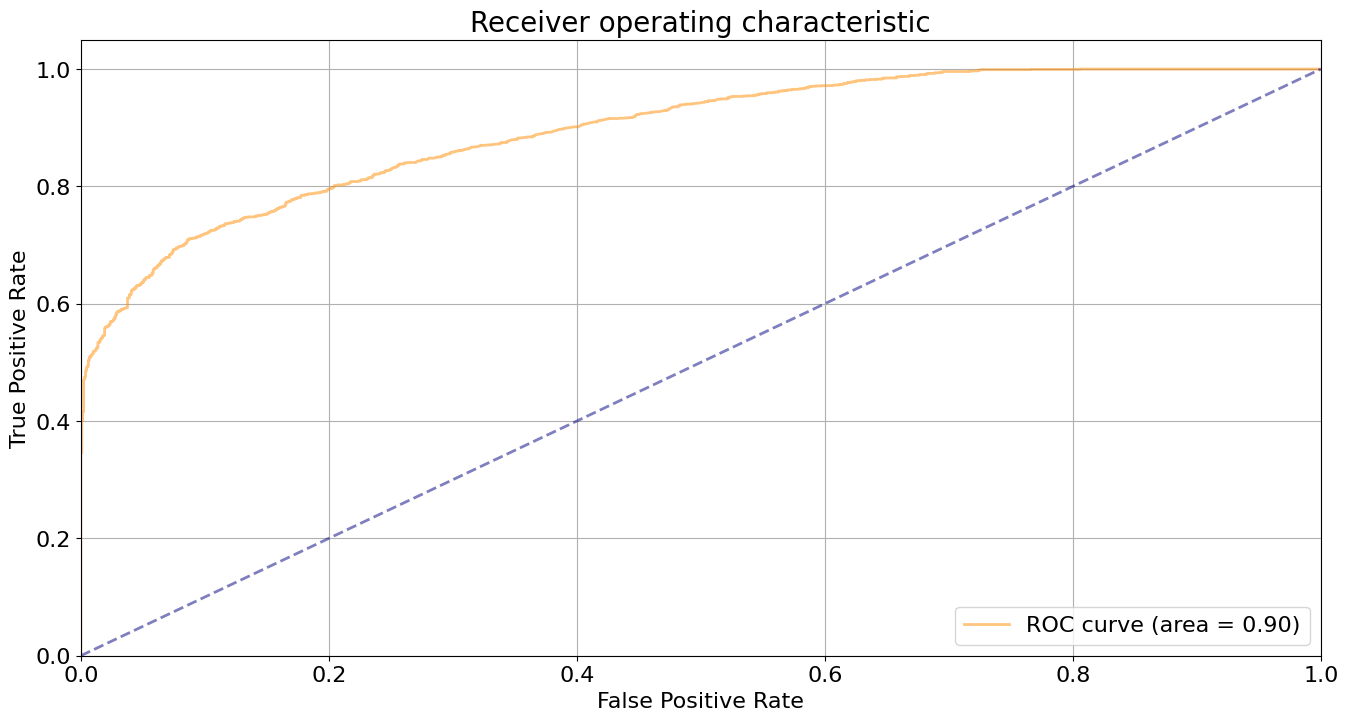

In [23]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

curve = get_roc_curve(cbc_1, pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [24]:
print('error:', 1-np.mean(preds == np.ravel(y_test)))


error: 0.20186915887850465


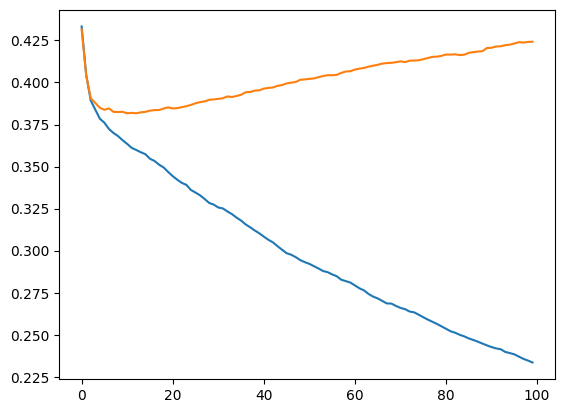

In [25]:
rmse_learn = pd.read_csv(
    'catboost_info/learn_error.tsv', header=0, delimiter='\t')
rmse_test = pd.read_csv('catboost_info/test_error.tsv',
                        header=0, delimiter='\t')
plt.plot(rmse_learn['Logloss'], label="Learn Error")
plt.plot(rmse_test['Logloss'], label="Test Error")


## Model Analysis

In [26]:
shap.initjs()

In [27]:
shap_values = cbc_1.get_feature_importance(pool, type="ShapValues")

In [28]:
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]


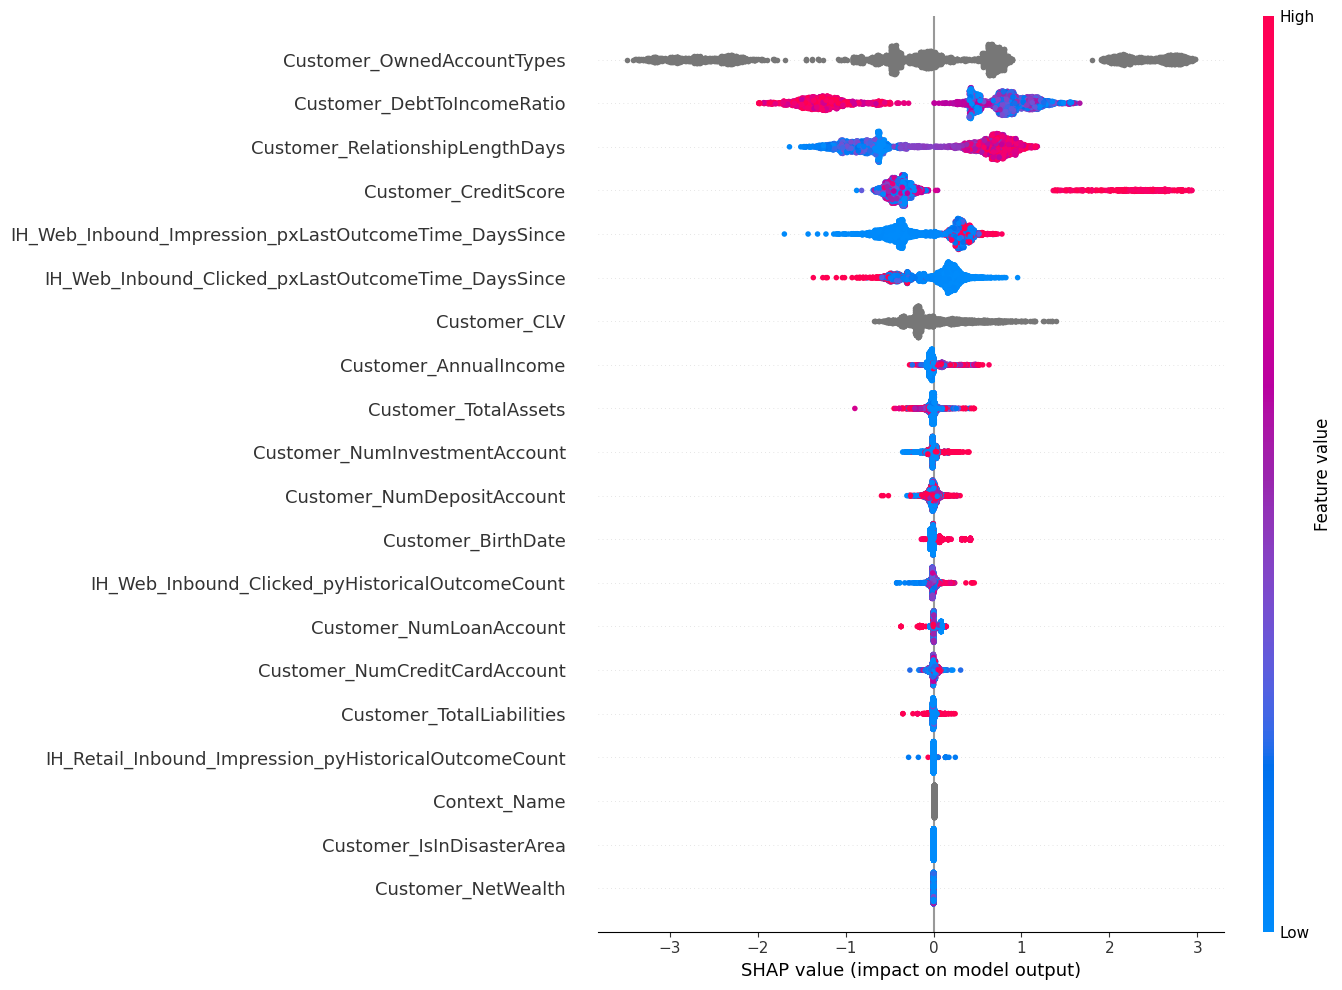

In [29]:
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=[14,10])


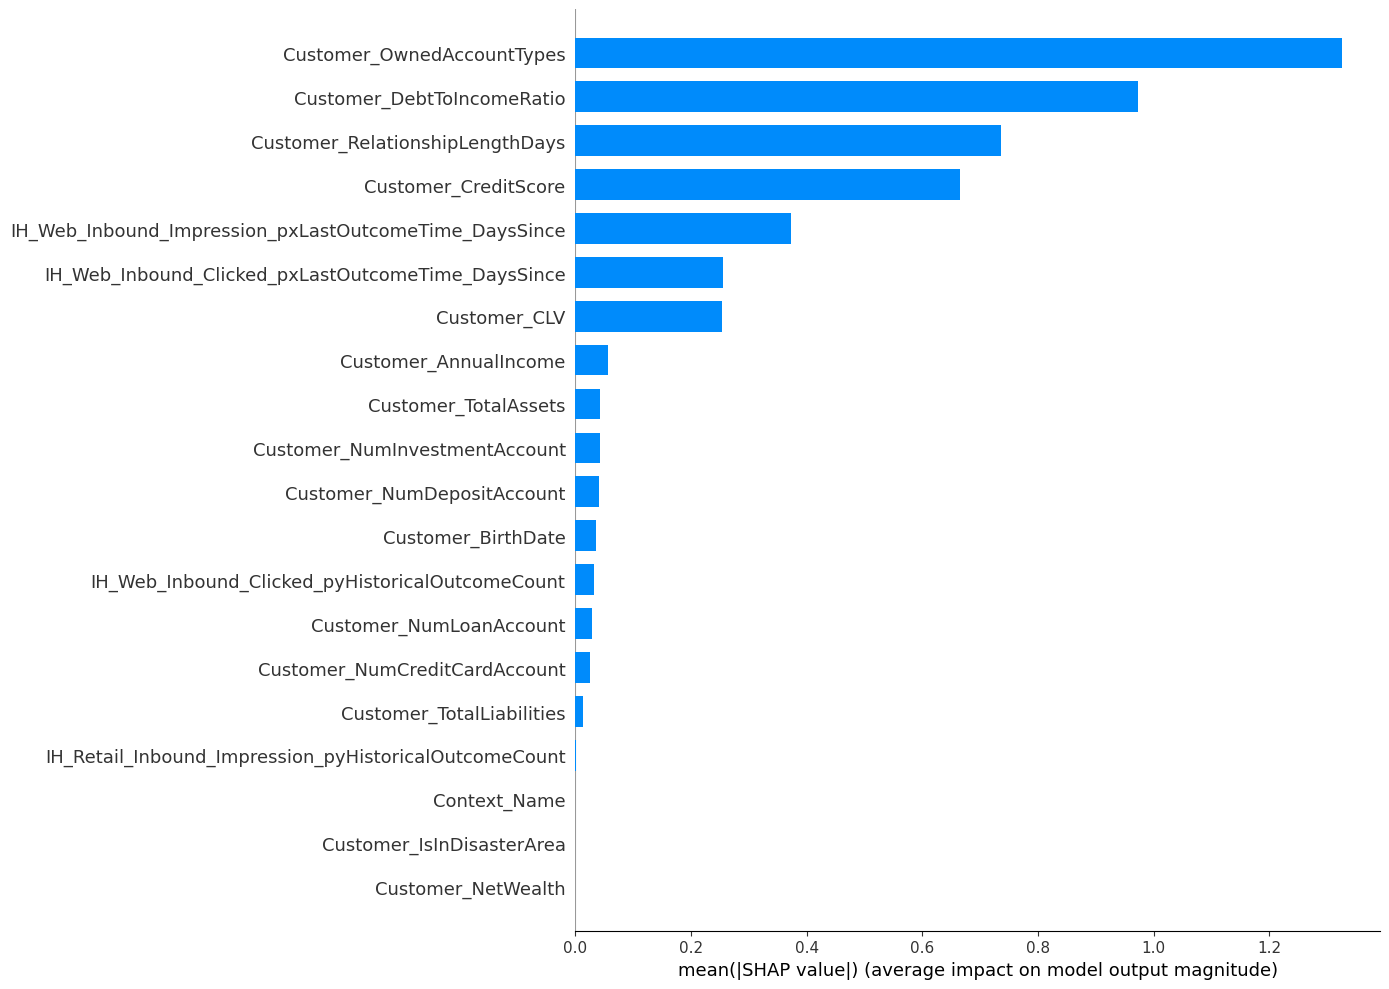

In [30]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=[14,10])

## Prediction Explanations

In [31]:

shap.plots.force(expected_value, shap_values[50], feature_names=X_test.columns)


## Individual Feature Analysis

In [32]:
feature = ['Customer_DebtToIncomeRatio', 'Customer_CreditScore', 'Customer_CLV', 'Customer_RelationshipLengthDays']
res = cbc_1.calc_feature_statistics(X_test, y_test, feature, plot=True)

### Analyse Model Without Text Features

In [33]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'] + text_features, axis=1)
seed = 127
test_size = 0.2
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train2, y_train2, test_size=test_size, random_state=seed)

In [34]:
params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }

In [35]:
%%time
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X=X_train2, y=y_train2,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val2, y_val2),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8208886	best: 0.8208886 (0)	total: 14.4ms	remaining: 1.43s
50:	test: 0.8817089	best: 0.8890395 (9)	total: 903ms	remaining: 868ms
99:	test: 0.8757605	best: 0.8890395 (9)	total: 1.69s	remaining: 0us

bestTest = 0.8890394625
bestIteration = 9

Shrink model to first 10 iterations.
CPU times: user 3.01 s, sys: 306 ms, total: 3.32 s
Wall time: 1.81 s


In [36]:
def print_score_diff(first_model, second_model):
    first_accuracy = first_model.best_score_['validation']['AUC']
    second_accuracy = second_model.best_score_['validation']['AUC']

    gap = (second_accuracy - first_accuracy) / first_accuracy * 100

    print('{} vs {} ({:+.2f}%)'.format(first_accuracy, second_accuracy, gap))
print('Model AUC difference - without text features vs with text features.')
print_score_diff(cbc_2, cbc_1)

Model AUC difference - without text features vs with text features.
0.8890394624625784 vs 0.8913656058677274 (+0.26%)


In [37]:
explainer = shap.TreeExplainer(cbc_2)
shap_values_exp = explainer(X_test2)

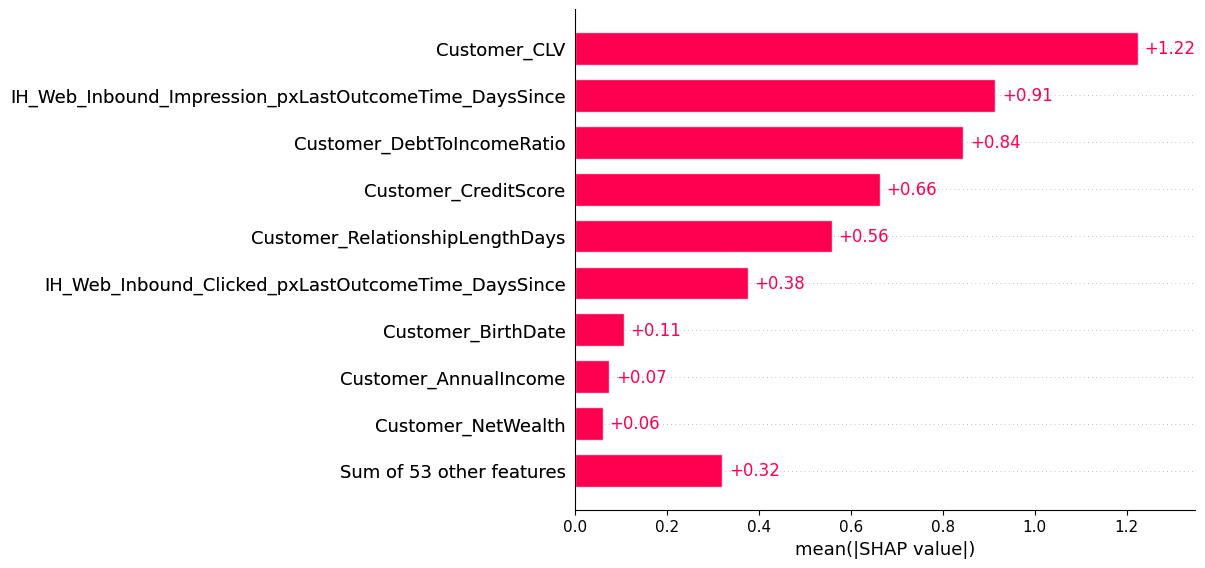

In [38]:
shap.plots.bar(shap_values_exp)

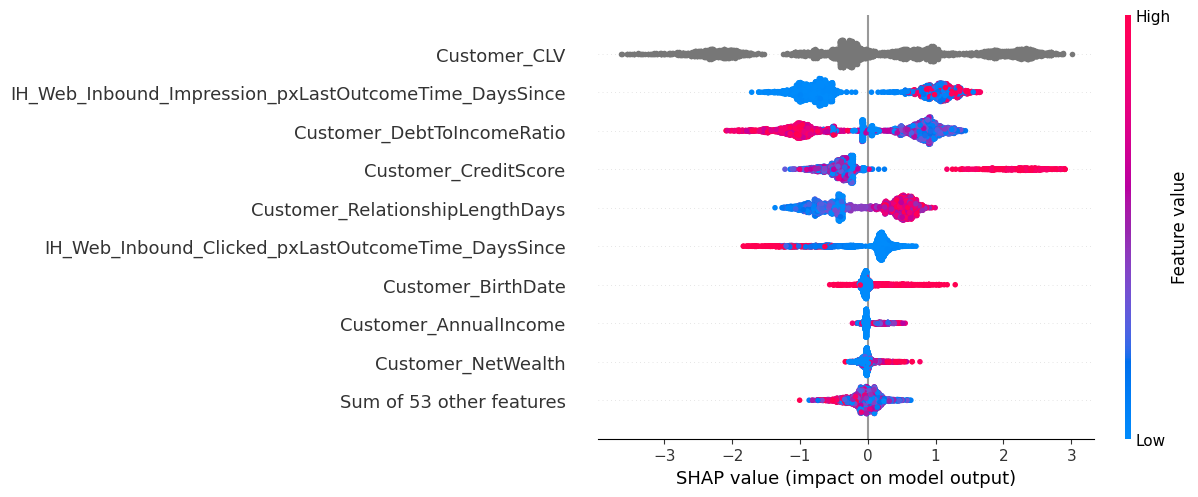

In [39]:
shap.plots.beeswarm(shap_values_exp)

In [40]:
shap.plots.force(explainer(X_test2.sample(n=500, random_state=seed)))

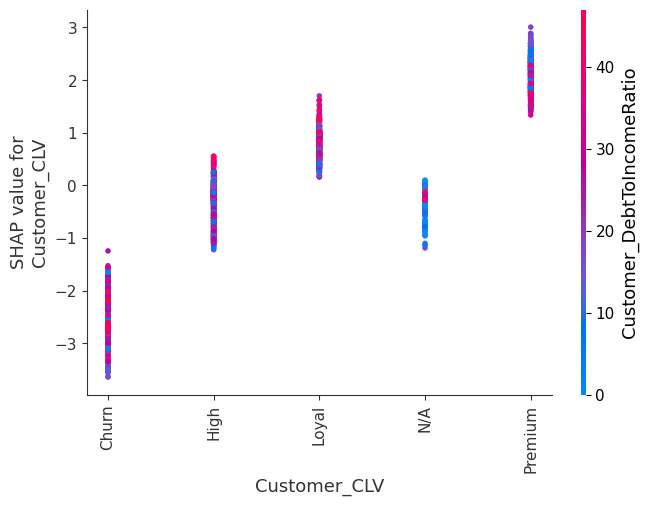

In [41]:
shap.dependence_plot("Customer_CLV", shap_values_exp.values, X_test2, interaction_index="Customer_DebtToIncomeRatio")

### Individual Predition Explanation

In [42]:
shap.plots.force(shap_values_exp[8])

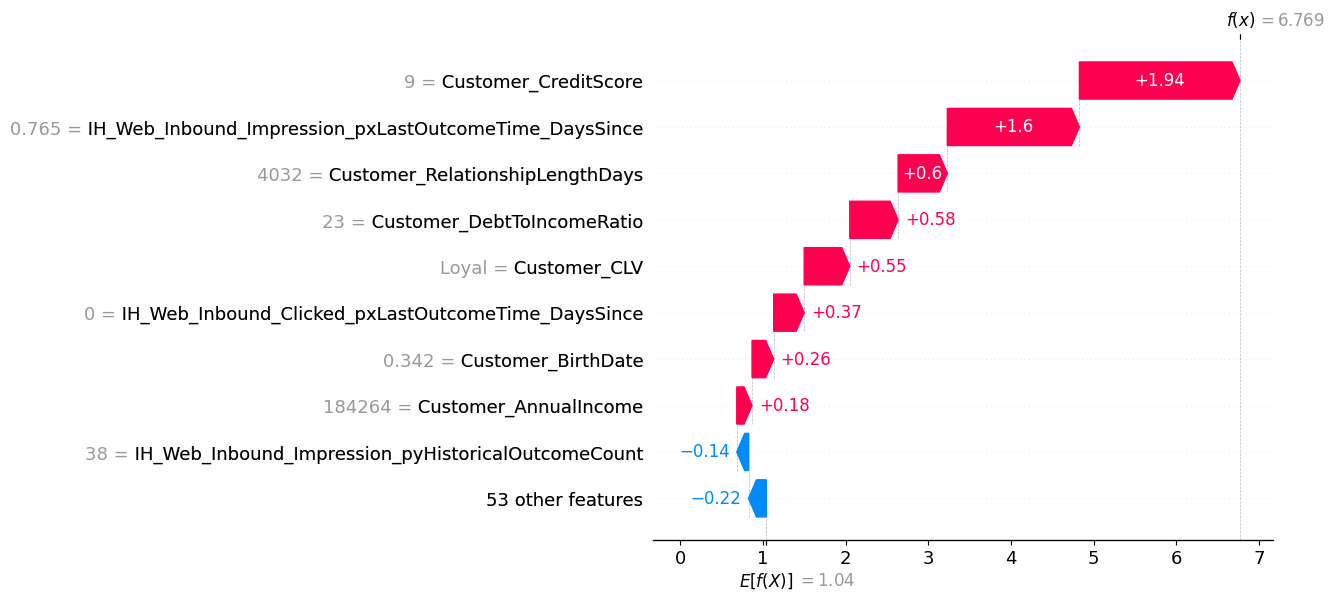

In [43]:
shap.plots.waterfall(shap_values_exp[8])

In [44]:
preds_proba = cbc_2.predict_proba(X_test2.iloc[8])
print(preds_proba)

[0.00114783 0.99885217]


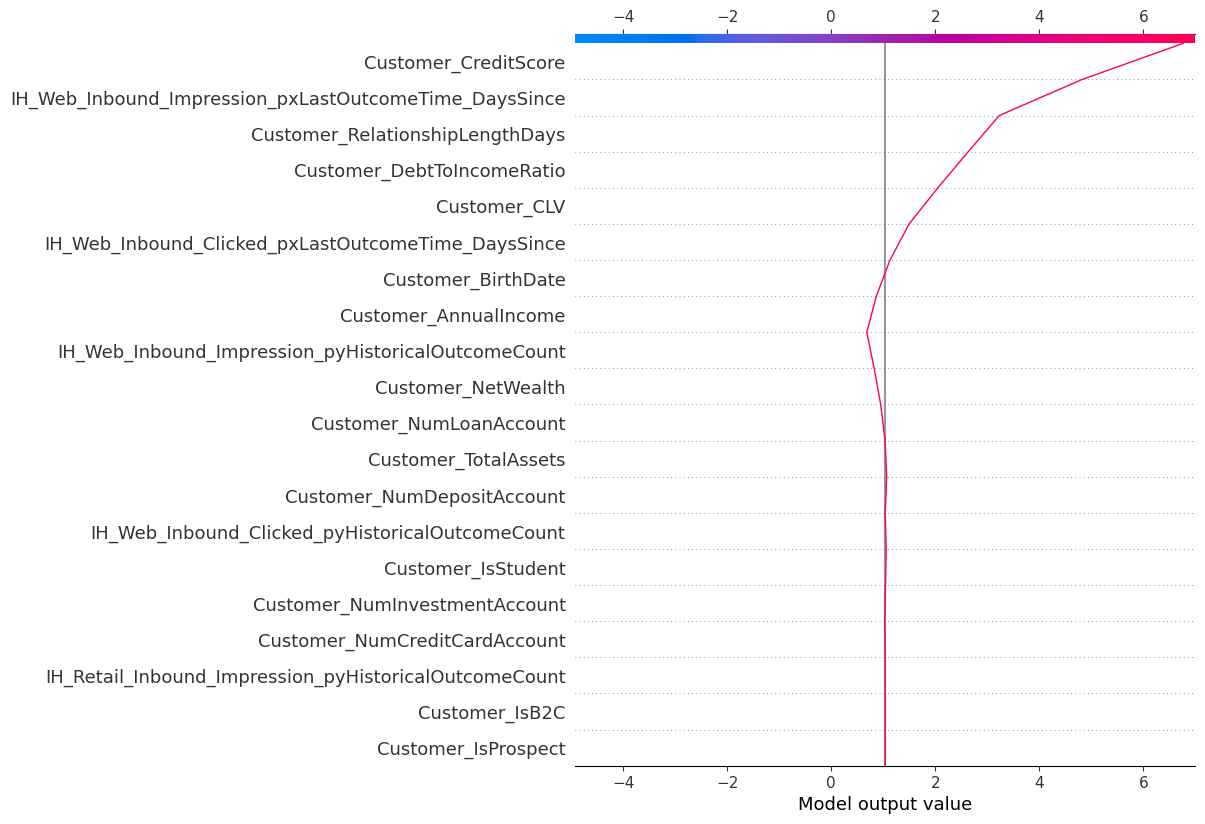

In [45]:
shap.decision_plot(
    base_value=np.array([explainer.expected_value]),
    shap_values=explainer.shap_values(X_test2)[8],
    features=X_test2.columns
)

### Feature dependency

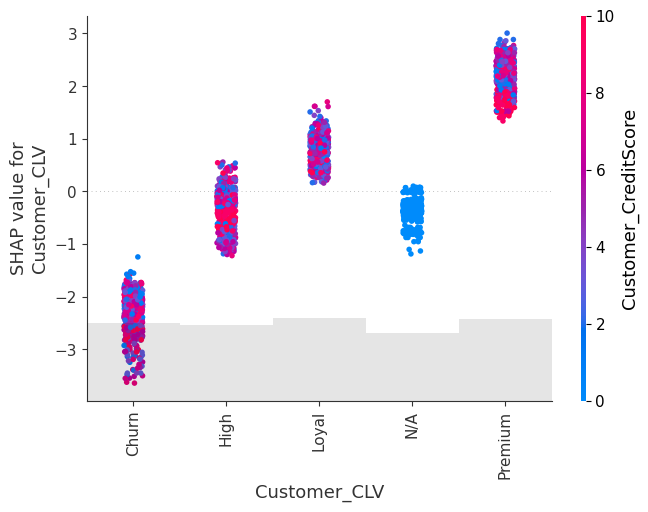

In [46]:
feature = 'Customer_CLV'
shap.plots.scatter(shap_values_exp[:, feature], color=shap_values_exp[:, "Customer_CreditScore"])

### Using global feature importance orderings

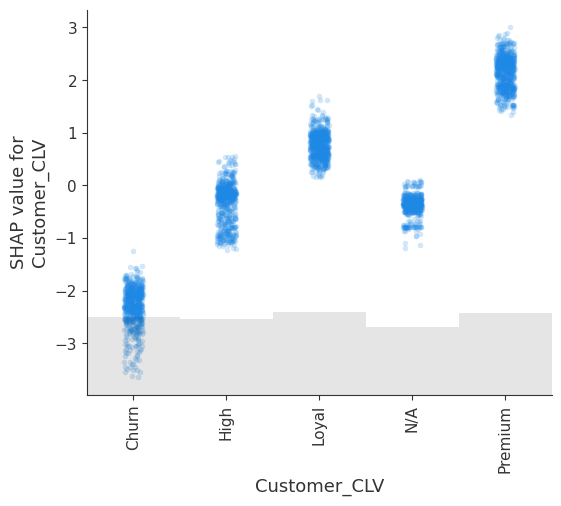

In [47]:
shap.plots.scatter(shap_values_exp[:, shap_values_exp.abs.mean(0).argsort[-1]], alpha=0.2)

## Model Calibration Quality

In [48]:
import numpy as np

# Calibration curves
def calibration(groundtruth, probs):
    # Convert groundtruth to binary and ensure probabilities are in a DataFrame
    groundtruth_binary = 1*np.array(groundtruth)
    nlabels = len(np.unique(groundtruth))
    
    if nlabels < 2:
        return pl.DataFrame({
            "MeanProbs": [0.5],
            "PositivesShare": [None],
            "binPos": [None],
            "binNeg": [None]
        })

    if nlabels > 2:
        raise ValueError("'groundtruth' has more than two levels.")
    
    # Create probabilities DataFrame with binning
    probabilities = pl.DataFrame({
        "groundtruth": groundtruth_binary,
        "probs": probs
    })

    # Group and summarize probabilities
    grouped_probabilities = (probabilities
                             .with_columns((pl.col("probs") * 10).round().alias("bin"))  # Binning probs to 1 decimal place
                             .group_by("bin")
                             .agg([
                                 pl.mean("probs").alias("MeanProbs"),
                                 pl.sum("groundtruth").alias("binPos"),
                                 (pl.count("groundtruth") - pl.sum("groundtruth")).alias("binNeg"),
                                 (pl.sum("groundtruth") / pl.count("groundtruth")).alias("PositivesShare")
                             ])
                             .sort("bin"))
    return grouped_probabilities

In [49]:
y_test_bin = y_test.apply(lambda x: x == 'Clicked')
preds_proba = cbc_1.predict_proba(X_test)
calibration_data = calibration(y_test_bin, preds_proba[:,1])

In [50]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(calibration_data, 
              x="MeanProbs", 
              y="PositivesShare")


# Add ideal calibration line (diagonal)
fig.add_shape(type="line", line=dict(dash='dash', color="darkred"), row='all', col='all', x0=0, y0=0, x1=1, y1=1)

# Customize the layout and labels
fig.update_layout(
    title="Model calibration plot",
    xaxis_title="Mean predicted probability",
    yaxis_title="Fraction of positives"
)

fig.show()